<center>
<h1>Digital Epidemiology</h1>
<h2>Assignment 1</h2>
<h2>Alessandro Gallo</h2>
</center>

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
%matplotlib inline
from random import choice
import time

# PART 1
## 1.1 Degree distribution of the graph.

### Prepare the graph

The graph was downloaded to http://snap.stanford.edu/data/as.html and represents the connections between Autonomous Systems (AS), subgraphs made by the routers that together constitute the connections in the Internet. The dataset contains 733 daily instances which span an interval of 785 days from November 8 1997 to January 2 2000.

In [2]:
# Initialize the graph
G = nx.Graph ()
# Graph dataset
file = 'data/as20000102.txt'
# Load the dataset and clean it
G = nx.read_adjlist(file , delimiter = '\t', create_using = nx.DiGraph())
print "Is it a directed graph? %s, i'll make it undirected" % G.is_directed()
# Make undirectede the graph
G=G.to_undirected()
print "Connected components: %s" % nx.number_connected_components(G)
print "N° of nodes: %s" % len(G.nodes())
print "N° of edges: %s" % len(G.edges())

Is it a directed graph? True, i'll make it undirected
Connected components: 1
N° of nodes: 6474
N° of edges: 13895


### Degree Distribution

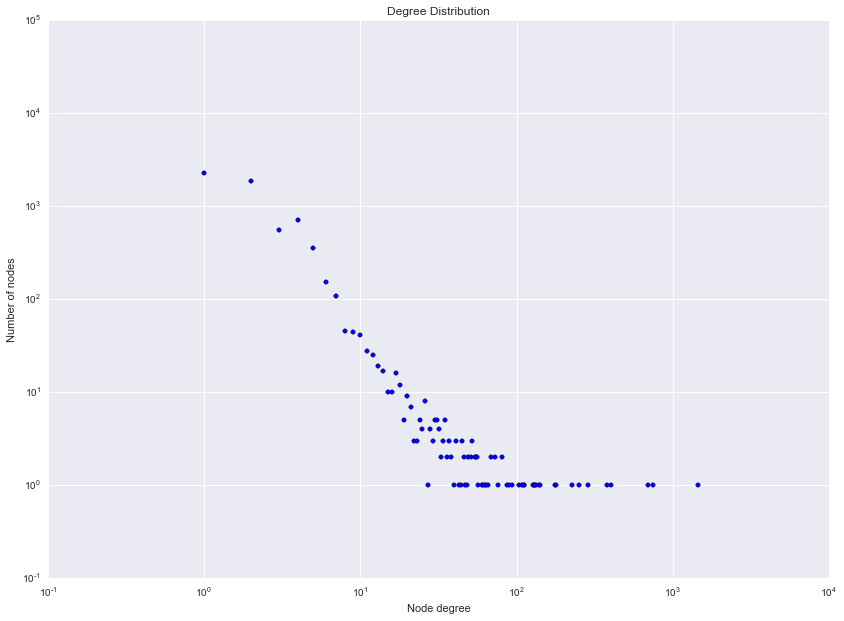

In [28]:
dic = {}
for n in G.nodes():
    d = G.degree(n)
    if d not in dic:
        dic[d] = 0
    dic[d] += 1
fig = plt.figure(figsize=(14,10))
fig.add_subplot(111).scatter([x for (x ,y) in sorted (dic.items())] , [y for (x, y) in sorted (dic.items())])
fig.add_subplot(111).set_xscale ('log'), fig.add_subplot(111).set_yscale ('log')
plt.ylabel('Number of nodes'), plt.xlabel('Node degree'), plt.title ("Degree Distribution"), plt.ylim(pow(10,-1),pow(10,5))
plt.show()

##  1.2 Simulation of the SIR epidemic model and epidemic curve

### Simulation function

The function takes in input the graph, $\mu$ , $\beta$ and (in case) the sentinels and runs the simulation of the SIR model on the given graph. If we don't consider sentinels nodes in the inputs the function returns I_net, otherwise it returns the average arrival times of the desease to the sentinels

In [4]:
# Simulation function
def simulation(G, mu, beta, sentinels):
    
    # set up initial state of the system

    # list of infected nodes
    infected_nodes = [ seed ]

    # we need to store the disease status of each node
    # S=0, I=1, R=-1
    G.disease_status = dict((n,0) for n in G.nodes())
    G.disease_status[seed] = 1

    # create a directed graph to represent the invasion tree
    G_inv = nx.DiGraph()
    G_inv.add_nodes_from(G.nodes())
    
    I_net,times,time,mt = [],{},0,0  # used to store the history of the system
    
    # loop until there are infectious nodes
    while len(infected_nodes) > 0:
    # store state:
    # each item is a tuple of the form (<number of infected nodes>, <node dictionary>),
    # where <node dictionary> has node IDs as keys and node disease status as values.
        I_net.append( (len(infected_nodes), G.disease_status.copy()) )
    
        time=time+1
    
    # TRANSMISSION: loop over infectious nodes
        for i in infected_nodes:
        # loop over the neighbors of infectious nodes
            for j in G.neighbors(i):
                if G.disease_status[j] == 0:
                # here j is a susceptible neighbor of infectious node i
                    p = np.random.random()
                    if p < beta:
                        G.disease_status[j] = 1 # node j has now been infected
                    # add edge i->j to invasion tree
                        G_inv.add_edge(i, j)
                        if j in sentinels:
                            times[j]=time
    
        # RECOVERY
        for k in infected_nodes:
            p = np.random.random()
            if p < mu:
                G.disease_status[k] = -1
    
    # update list of infectious nodes
        infected_nodes = []
        for n in G.nodes():
            if G.disease_status[n] == 1:
                infected_nodes.append(n)
 
    I_net.append( (len(infected_nodes), G.disease_status.copy()))
    mt=np.mean(times.values())
    
    if sentinels==[]:
        return(I_net)
    else:
        return(mt)

### Run simulation

We choose $\mu$=0.02 and $\beta$=0.08 and start the simulation.

In [5]:
mu, beta = 0.02 , 0.08  # mu = infectious period 
                        # beta = probability of infection given a contact
seed = (sorted(G.degree_iter(), key=itemgetter(1)))[-1][0]
# Start the simulation (the empty input will be used later for the sentinels)
I_net=simulation(G, mu, beta, [])

C:\Users\User\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


### Epidemic curve

Total number of nodes 6474
The total number of recovered nodes is 6023
The final attack rate is 0.930336731542
The epidemic is over at time 426


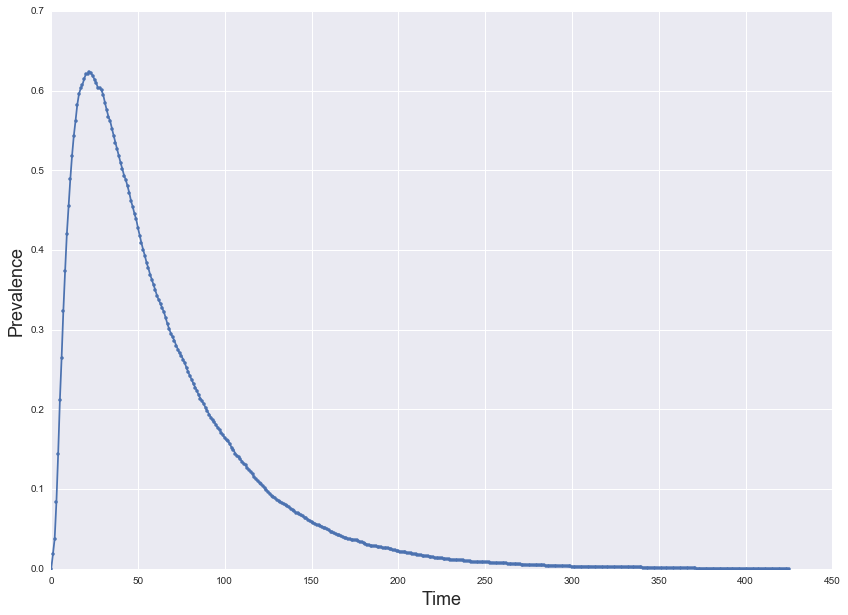

In [27]:
# Plot the epidemic curve
plt.figure(figsize=(14,10)), plt.xlabel('Time', fontsize=18), plt.ylabel('Prevalence', fontsize=18)
plt.plot(xrange(0,len(I_net)), [float(n)/len(G.nodes()) for n, state in I_net], '.-' )

#Some informations
print "Total number of nodes", G.number_of_nodes()
print "The total number of recovered nodes is", len([n for n in G.disease_status if G.disease_status[n] == -1])
print "The final attack rate is", float(len([n for n in G.disease_status if G.disease_status[n] == -1]))/len(G.nodes())
print "The epidemic is over at time", len(I_net)

# PART 2
## 2.1 Distribution of arrival times for many realizations of the epidemic with sentinel nodes

### Prepare the sentinels

In [7]:
# Choose random nodes from the graph representing the 1% of the total nodes
sentinels = np.random.choice(G.nodes(), size=int(round(len(G))*0.01), replace=False)
# N° of simulations
n_sim=300
# Make a sentinels matrix for the simulation (in this case the sentinels rows are all the same)
matrix = [sentinels for y in range(n_sim)]

### Start the simulations

In [8]:
#Start the simulation
tot_times = [simulation(G, mu, beta,matrix[i]) for i in range(n_sim)]

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


### Boxplot of the arrival times

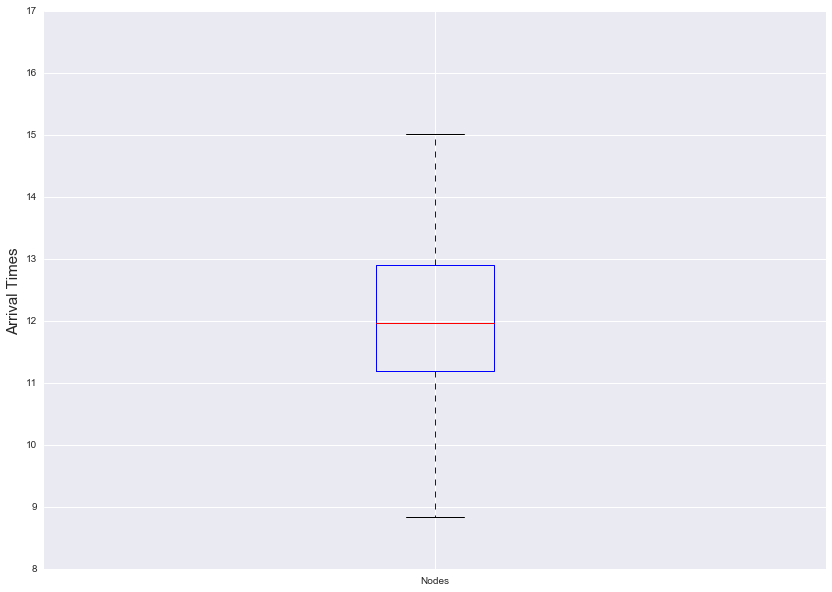

In [25]:
# Boxplot of the arrival times
plt.figure(figsize=(14,10)), plt.ylabel('Arrival Times', fontsize=15)
p=plt.boxplot(tot_times,labels=['Nodes'])

## 2.2 Distribution of arrival times with many random choices for the N sentinel nodes

### Start the simulations with random sentinels

In [10]:
# Let's make now a sentinels matrix with random choises of the sentinels
matrix = [np.random.choice(G.nodes(), size=int(round(len(G))*0.01), replace=False) for y in range(n_sim)]
#Start the simulations with the new matrix
tot_times = [simulation(G, mu, beta,matrix[i]) for i in range(n_sim)]

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


### Boxplot of the arrival times with random sentinels

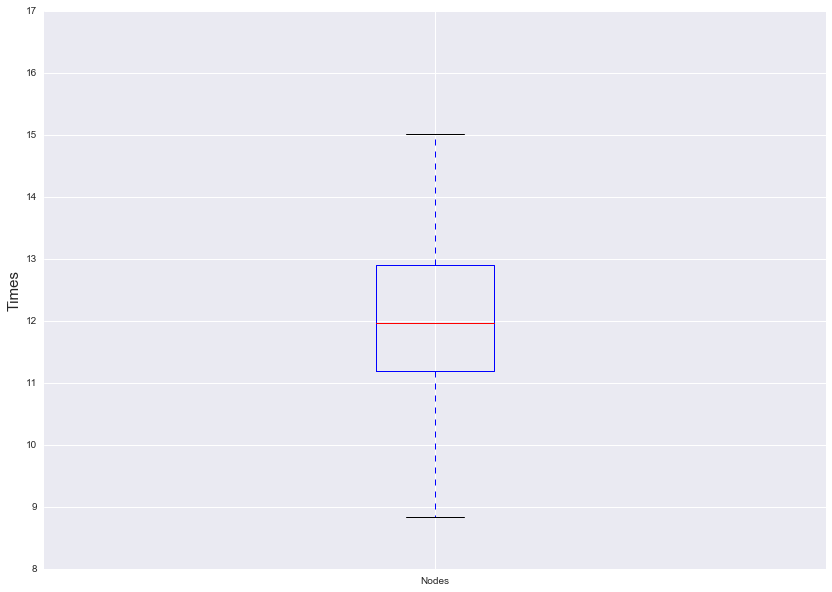

In [24]:
#Boxplot of the arrival times
plt.figure(figsize=(14,10)), plt.ylabel('Times', fontsize=15)
p=plt.boxplot(tot_times,labels=['Nodes'])

## 2.3 Different metrics, different sentinels, different results

### Degree Centrality

In [12]:
dc_bottom=[tup[0] for tup in sorted(nx.degree_centrality(G).items(), key=lambda x: x[1])[:int(round(len(G))*0.01)]]
dc_top=[tup[0] for tup in sorted(nx.degree_centrality(G).items(), key=lambda x: x[1])[-int(round(len(G))*0.01):]]
tot_times_dc_bot = [simulation(G, mu, beta,dc_bottom) for i in range(n_sim)]
tot_times_dc_top= [simulation(G, mu, beta,dc_top) for i in range(n_sim)]

### Betweenness Centrality

In [13]:
bc_bottom=[tup[0] for tup in sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1])[:int(round(len(G))*0.01)]]
bc_top=[tup[0] for tup in sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1])[-int(round(len(G))*0.01):]]
tot_times_bc_bot = [simulation(G, mu, beta,bc_bottom) for i in range(n_sim)]
tot_times_bc_top= [simulation(G, mu, beta,bc_top) for i in range(n_sim)]

### Page Rank

In [14]:
pg_bottom=[tup[0] for tup in sorted(nx.pagerank(G).items(), key=lambda x: x[1])[:int(round(len(G))*0.01)]]
pg_top=[tup[0] for tup in sorted(nx.pagerank(G).items(), key=lambda x: x[1])[-int(round(len(G))*0.01):]]
tot_times_pg_bot = [simulation(G, mu, beta,pg_bottom) for i in range(n_sim)]
tot_times_pg_top= [simulation(G, mu, beta,pg_top) for i in range(n_sim)]

### Closeness Centrality

In [15]:
cc_bottom=[tup[0] for tup in sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1])[:int(round(len(G))*0.01)]]
cc_top=[tup[0] for tup in sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1])[-int(round(len(G))*0.01):]]
tot_times_cc_bot = [simulation(G, mu, beta,cc_bottom) for i in range(n_sim)]
tot_times_cc_top= [simulation(G, mu, beta,cc_top) for i in range(n_sim)]

### Boxplots of the metrics

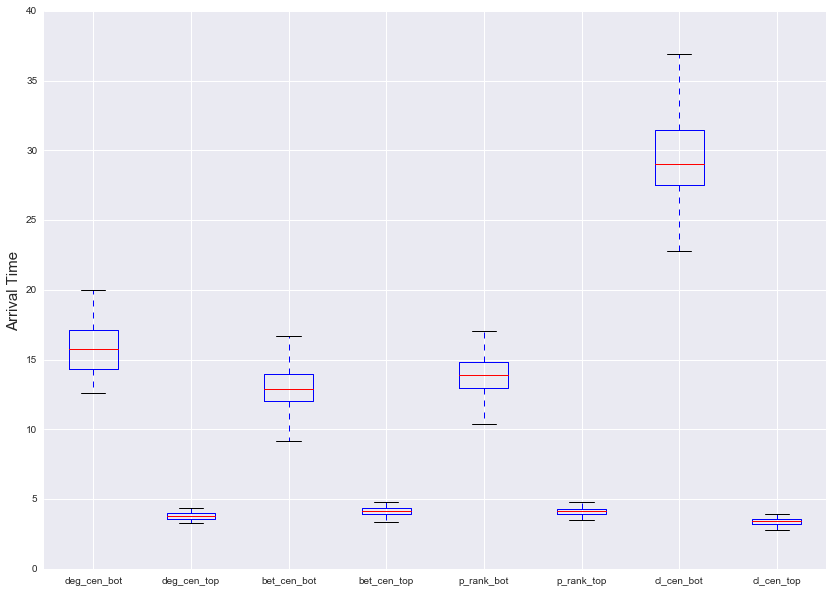

In [16]:
plt.figure(figsize=(14,10)), plt.ylabel('Arrival Time', fontsize=15)
data = [tot_times_dc_bot, tot_times_dc_top,tot_times_bc_bot,tot_times_bc_top, tot_times_pg_bot,tot_times_pg_top,tot_times_cc_bot,tot_times_cc_top]
labels = ['deg_cen_bot','deg_cen_top','bet_cen_bot','bet_cen_top','p_rank_bot','p_rank_top','cl_cen_bot','cl_cen_top']
p=plt.boxplot(data,labels=labels)

As we can see from the multiple boxplot, the choice of the sentinels influences the performance of the arrival time of the desease. The best N-nodes are the ones with high values of their respective algorithms, like top-N nodes of degree centrality or closeness centrality. We can understand this behaviour due to the fact that these kind of nodes facilitate the propagation of the desease to all the graph for their high centrality properties.

# PART 3
## 3.1  Strategies to reduce average detection time of the epidemic (no global knowledge)

### Prepare the sentinels

Let's image now that we just know the sentinels, their neighbors and arcs between them. How could we choose the sentinels with this poor local knowledge of the graph? First of all, let's select this subgraph.

In [17]:
# Create a subgraph where we just know the random sentinels, their neighbors and the arcs between them
sentinels = np.random.choice(G.nodes(), size=int(round(len(G))*0.01), replace=False)

#Subgraph
F = nx.Graph()
# For each sentinel x
for x in sentinels:
    # and for each neighbor y of the sentinel x
    for y in G.neighbors(x):
        # Make an edge between the sentinel x and its neighbor y (make the the edges between the sentinels and their neighbors)
        F.add_edge(x, y)
        # For each neighbor j of the neighbor y of the sentinel x
        for j in G.neighbors(y):
            # If j is one of the neighbors of x
            if j in G.neighbors(x):
                # add an edge between j and y (make the arcs between the neighbors of the sentinels)
                F.add_edge(j,y)

###  Standard case (random sentinels)

In [18]:
normal = [simulation(G, mu, beta,sentinels) for i in range(n_sim)]

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


### 1° :  Choose the sentinels among the nodes with the highest  Degree Centrality

In [19]:
dc_top=[tup[0] for tup in sorted(nx.degree_centrality(F).items(), key=lambda x: x[1])[-int(round(len(G))*0.01):]]
tot_times_dc_top= [simulation(G, mu, beta,dc_top) for i in range(n_sim)]

### 2° :  Choose the sentinels among the nodes with the highest Closeness Centrality

In [20]:
cc_top=[tup[0] for tup in sorted(nx.closeness_centrality(F).items(), key=lambda x: x[1])[-int(round(len(G))*0.01):]]
tot_times_cc_top= [simulation(G, mu, beta,cc_top) for i in range(n_sim)]

###  Boxplot of the cases

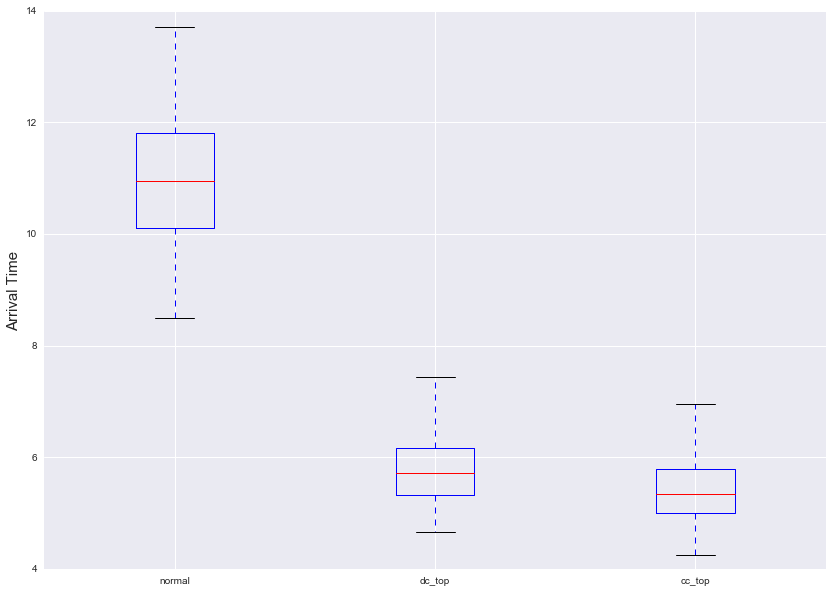

In [23]:
plt.figure(figsize=(14,10)), plt.ylabel('Arrival Time', fontsize=15)
data = [normal,tot_times_dc_top,tot_times_cc_top]
labels = ['normal','dc_top','cc_top']
p=plt.boxplot(data,labels=labels)

## 3.2  Why the strategies work

As we can see, despite the poor local knowledge of the graph, we were able to improve the performance of the arrival time of the desease by choosing the neighbor nodes of the sentinels with, for example, the highest degree centrality or closeness centrality. The strategies work because these properties facilitate the propagation of the desease. 
We certainly don't know if these nodes are, globally, a good choice; locally the nodes perform very well but, as a big fish in a small fish tank, if we had a greater knowledge of the graph we could know that other neighbor nodes we had are even better than the ones we chose.